In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transformation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit ResNet input
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard ResNet normalization
])

# Load dataset
dataset = datasets.ImageFolder(root='/blue/pinaki.sarder/harishwarreddy.k/public/data', transform=data_transforms)

# Split dataset into train, val, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])
# Create a WeightedRandomSampler only for the train_set after splitting
train_sampler = WeightedRandomSampler(
    weights=[class_weights[label] for _, label in train_set],
    num_samples=len(train_set),
    replacement=True
)

train_loader = DataLoader(train_set, batch_size=32, sampler=train_sampler, num_workers=4)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)

# Load a pre-trained ResNet model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # Modify final layer for binary classification
model = model.to(device)

# Define loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001)

/apps/pytorch/2.2.0/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/apps/pytorch/2.2.0/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
# Training function
def train(model, loader):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)

# Validation function
def validate(model, loader):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    return running_loss / len(loader.dataset), accuracy




In [24]:
# Training loop with validation for early stopping/fine-tuning
num_epochs = 20
best_val_acc = 0.0
for epoch in range(num_epochs):
    train_loss = train(model, train_loader)
    val_loss, val_acc = validate(model, val_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"New best model saved with accuracy: {best_val_acc:.4f}")


Epoch 1/20, Train Loss: 0.1235, Val Loss: 0.0443, Val Acc: 0.9798
New best model saved with accuracy: 0.9798
Epoch 2/20, Train Loss: 0.0479, Val Loss: 0.0913, Val Acc: 0.9451
Epoch 3/20, Train Loss: 0.0344, Val Loss: 0.0888, Val Acc: 0.9581
Epoch 4/20, Train Loss: 0.0271, Val Loss: 0.0531, Val Acc: 0.9798
Epoch 5/20, Train Loss: 0.0236, Val Loss: 0.0141, Val Acc: 0.9928
New best model saved with accuracy: 0.9928
Epoch 6/20, Train Loss: 0.0308, Val Loss: 0.5315, Val Acc: 0.8049
Epoch 7/20, Train Loss: 0.0249, Val Loss: 0.0669, Val Acc: 0.9754
Epoch 8/20, Train Loss: 0.0194, Val Loss: 0.0166, Val Acc: 0.9957
New best model saved with accuracy: 0.9957
Epoch 9/20, Train Loss: 0.0104, Val Loss: 0.0293, Val Acc: 0.9884
Epoch 10/20, Train Loss: 0.0035, Val Loss: 0.0523, Val Acc: 0.9884
Epoch 11/20, Train Loss: 0.0198, Val Loss: 0.1315, Val Acc: 0.9639
Epoch 12/20, Train Loss: 0.0055, Val Loss: 0.1783, Val Acc: 0.9697
Epoch 13/20, Train Loss: 0.0159, Val Loss: 0.0349, Val Acc: 0.9812
Epoch 14/

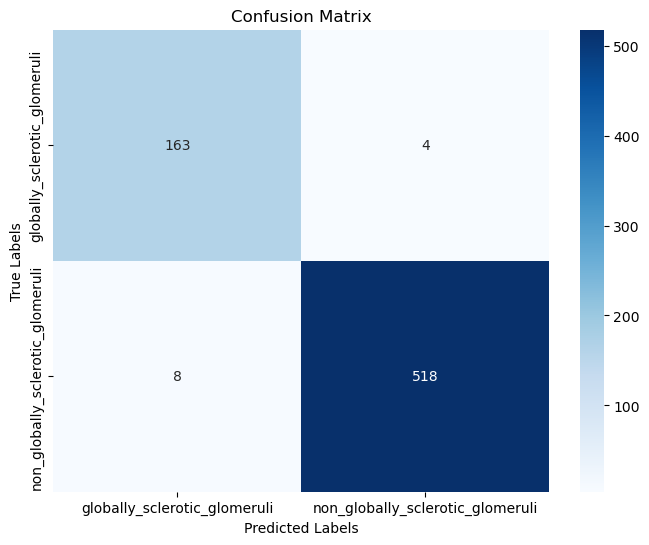

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import torch

# Define the test function to generate predictions and plot confusion matrix
def test_and_confusion_matrix(model, loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    # Save the plot
    plt.savefig("confusion_matrix.png")
    plt.show()

# Load best model for testing and generate the confusion matrix
model.load_state_dict(torch.load('best_model.pth'))
test_and_confusion_matrix(model, test_loader)